In [1]:
'''
Statistical and Machine Learning Methods in Particle and Astrophysics

TUM - summer term 2019
applications of probability theory and classical statisti
M. Agostini <matteo.agostini@tum.de> and Hans Niederhausen <hans.niederhausen@tum.de>

Thanks to the following contributors:
    Martin Ha Minh (significant contributions to "IcecubeSim" a pseudo event generator for educational purposes)
'''

# start by generating some pseudo IceCube Monte Carlo events
from generate_mcevents import generate_pseudoMC

nevents = 1.e6

# the line below will generate the MC events and write them to disk
# this needs to be done only once.
# if the MC events have already been generated in a previous step
# simply comment out the line below.
#outfiles = generate_pseudoMC(nevents)

# insted, if the MC events already exist on disk
# simply uncomment the line below
# and no events will be newly generated but the location of the MC events on disk will be returned
outfiles = generate_pseudoMC(nevents, precomputed=True) 

In [2]:
import pandas as pd
import numpy as np

# explore datasets
print "listing datasets"
print outfiles
print ""

df_nueNC = pd.read_hdf(outfiles['nue_NC'])
df_nueCC = pd.read_hdf(outfiles['nue_CC'])
df_numuNC = pd.read_hdf(outfiles['numu_NC'])

# combine dataframes
df = pd.concat([df_nueNC, df_nueCC, df_numuNC])

# the combined dataframe should contain 3 * nevents rows (one per event)
print "found", len(df), "/", 3*nevents, "events in dataframe."
print ""

# generated quantities
print "listing generated quantities"
print sorted(df.columns.values)
print ""

listing datasets
{'nue_NC': './output/nue_NC_simulation_gamma_1.1_lEmin_3.0_lEmax_7.0_nsamples_1000000.h5', 'numu_NC': './output/numu_NC_simulation_gamma_1.1_lEmin_3.0_lEmax_7.0_nsamples_1000000.h5', 'nue_CC': './output/nue_CC_simulation_gamma_1.1_lEmin_3.0_lEmax_7.0_nsamples_1000000.h5'}

found 3000000 / 3000000.0 events in dataframe.

listing generated quantities
['bjorken_y', 'conv_flux', 'dep_energy', 'generation_weight', 'interaction_type', 'prim_azimuth', 'prim_coszenith', 'prim_energy', 'prim_type', 'rec_azimuth', 'rec_coszenith', 'rec_energy']



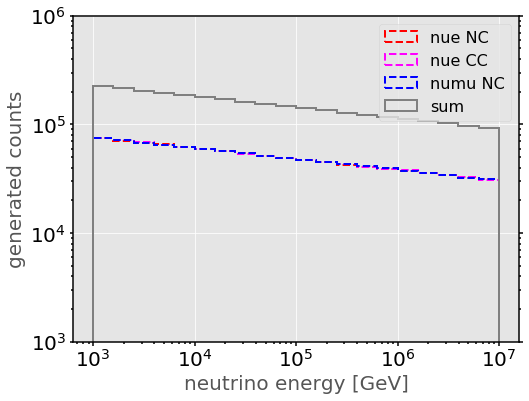

In [4]:
# plot generated quantities
# neutrino energy

var = 'prim_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(3.0, 7.0, 21)
edges = 10**edges

contents, bins, _ = plt.hist(df_nueNC[var], bins=edges, histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df_nueCC[var], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df_numuNC[var], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e3, 1.e6])

ax.set_xlabel('neutrino energy [GeV]', fontsize=20)
ax.set_ylabel('generated counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

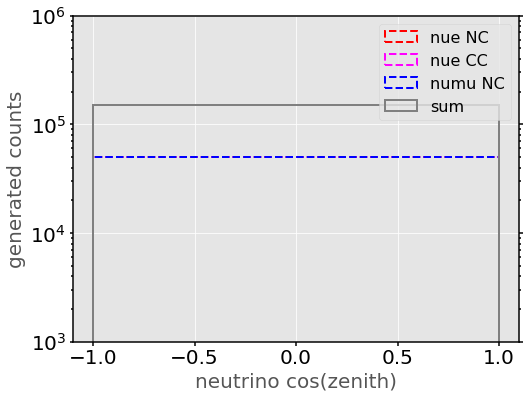

In [4]:
# plot generated quantities
# neutrino zenith angle

var = 'prim_coszenith'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(-1.0, 1.0, 21)

contents, bins, _ = plt.hist(df_nueNC[var], bins=edges, histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df_nueCC[var], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df_numuNC[var], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_ylim([1.e3, 1.e6])

ax.set_xlabel('neutrino cos(zenith)', fontsize=20)
ax.set_ylabel('generated counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

In [5]:
# these are obviously "unphysical" and reflect the injected distributions
# need to account for "physics" through importance weights (or MC weights, event weights ...)
# in our example the weights consist of a generation weight and a flux weight

# the flux of astrophysical neutrinos is assumed to follow a powerlaw
def astro_flux(prim_energies):
    gamma = 2.0
    norm = 1.0 * 10**(-18) # units of 1/(GeV cm^2 sr s)
    ltime = 3 * 365 * 24 * 3600 # 3 years of detector operation
    
    return np.power(df['prim_energy']/1.e5,-gamma) * norm * ltime


weights_astro=df['generation_weight'].values * astro_flux(df['prim_energy'].values)

# we can use indexing to extract the individual components (nue NC, nue CC, numu NC)
# from the combined dataframe

idx_nueCC = np.logical_and(df['prim_type']==12.0, df['interaction_type']==1.0)
idx_nueNC = np.logical_and(df['prim_type']==12.0, df['interaction_type']==2.0)
idx_numuNC = np.logical_and(df['prim_type']==14.0, df['interaction_type']==2.0)

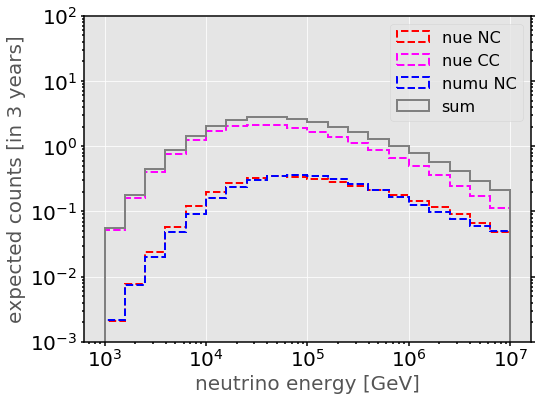

In [6]:
var = 'prim_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(3.0, 7.0, 21)
edges = 10**edges

contents, bins, _ = plt.hist(df[idx_nueNC][var], weights=weights_astro[idx_nueNC], bins=edges,  histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df[idx_nueCC][var], weights=weights_astro[idx_nueCC], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df[idx_numuNC][var], weights=weights_astro[idx_numuNC], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], weights=weights_astro, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e-3, 1.e2])

ax.set_xlabel('neutrino energy [GeV]', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

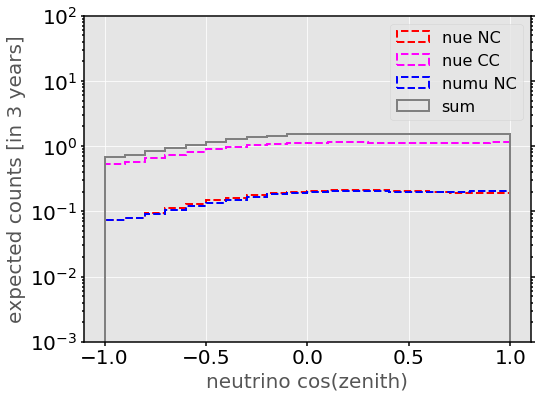

In [7]:
var = 'prim_coszenith'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(-1.0, 1.0, 21)


contents, bins, _ = plt.hist(df[idx_nueNC][var], weights=weights_astro[idx_nueNC], bins=edges,  histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df[idx_nueCC][var], weights=weights_astro[idx_nueCC], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df[idx_numuNC][var], weights=weights_astro[idx_numuNC], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], weights=weights_astro, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_ylim([1.e-3, 1.e2])

ax.set_xlabel('neutrino cos(zenith)', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

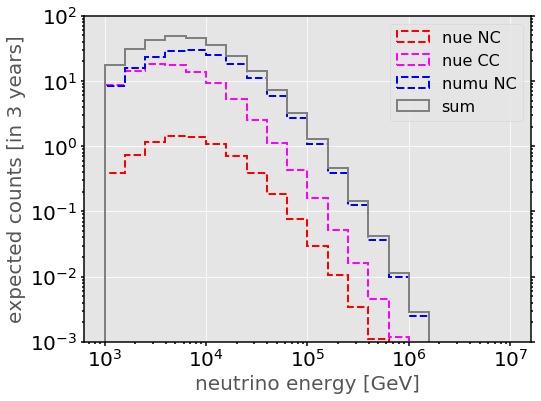

In [8]:
# so far we only accounted for the signal of astrophysical neutrinos
# how about the background from atmospheric neutrinos?

# the flux of atmospheric neutrinos can be calculated by different methods: from MC simulations (e.g. Honda et al.)
# or by solving differential equations (e.g. Fedynitch et al.) 
# we pre-computed the conventional atmospheric flux at each simulated point during the simulation already

var = 'prim_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(3.0, 7.0, 21)
edges = 10**edges

ltime = 3 * 365 * 24 * 3600


# we increase the conv background by a factor of 2, since the assumption of no contribution from numu CC
# is overly optimistic
df['conv_flux'] = df['conv_flux'] * 2.0
weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime

contents, bins, _ = plt.hist(df[idx_nueNC][var], weights=weights_conv[idx_nueNC], bins=edges,  histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df[idx_nueCC][var], weights=weights_conv[idx_nueCC], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df[idx_numuNC][var], weights=weights_conv[idx_numuNC], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], weights=weights_conv, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e-3, 1.e2])

ax.set_xlabel('neutrino energy [GeV]', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()


# notice how the atmospheric background prediction is larger in total but vanishes 
# towards higher energies more rapildy than the prediction from the astrophysical (signal) model.
# in addition the relative contributions from the two flavors are vastly different (numu dominates)

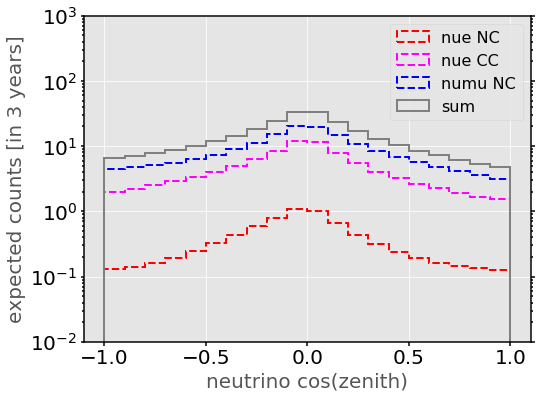

In [9]:
var = 'prim_coszenith'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(-1.0, 1.0, 21)

ltime = 3 * 365 * 24 * 3600
weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime

contents, bins, _ = plt.hist(df[idx_nueNC][var], weights=weights_conv[idx_nueNC], bins=edges,  histtype='step', color='red', linewidth=2, linestyle='dashed', label="nue NC")
contents, bins, _ = plt.hist(df[idx_nueCC][var], weights=weights_conv[idx_nueCC], bins=edges, histtype='step', color='magenta', linewidth=2, linestyle='dashed', label="nue CC")
contents, bins, _ = plt.hist(df[idx_numuNC][var], weights=weights_conv[idx_numuNC], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='dashed', label="numu NC")
contents, bins, _ = plt.hist(df[var], weights=weights_conv, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum")


ax.set_yscale('log')
ax.set_ylim([1.e-2, 1.e3])

ax.set_xlabel('neutrino cos(zenith)', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

# notice how the background component peaks at the horizon
# while the astrophysical component is more uniform (except for some earth absoprtion in the North)

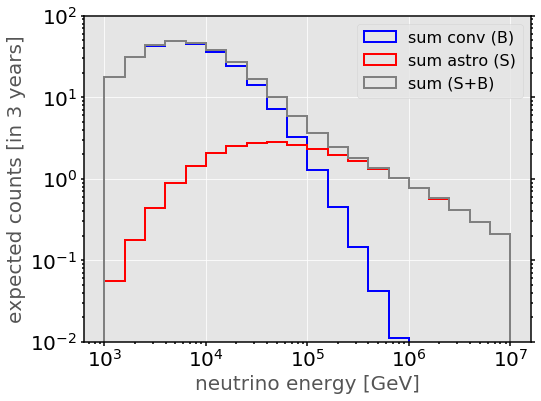

In [10]:
# since all components (nue NC, nue CC and numu NC) produce particle showers in the detector
# no particle ID is possible in this problem
# thus, experimentally, only the sum of the components is observable

var = 'prim_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(3.0, 7.0, 21)
edges = 10**edges

ltime = 3 * 365 * 24 * 3600
weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime

contents, bins, _ = plt.hist(df[var], weights=weights_conv, bins=edges, histtype='step', color='blue', linewidth=2, linestyle='solid', label="sum conv (B)")
contents, bins, _ = plt.hist(df[var], weights=weights_astro, bins=edges, histtype='step', color='red', linewidth=2, linestyle='solid', label="sum astro (S)")
contents, bins, _ = plt.hist(df[var], weights=weights_astro+weights_conv, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum (S+B)")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e-2, 1.e2])

ax.set_xlabel('neutrino energy [GeV]', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

# notice how the signal of astrophysical neutrinos is expected to become visible as a tail at highest energies
# this tail is what lead to the original discovery (and is what we want to measure in the exercise)

energy cut: 0.0 TeV



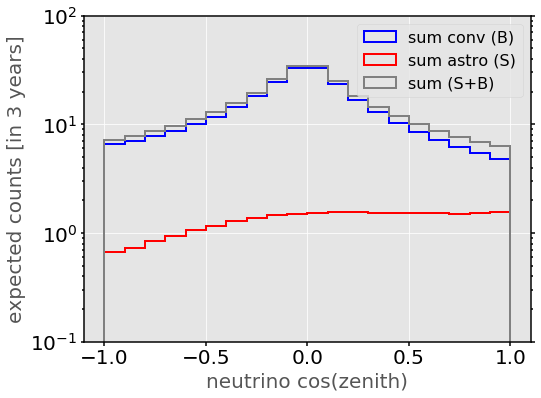

energy cut: 10.0 TeV



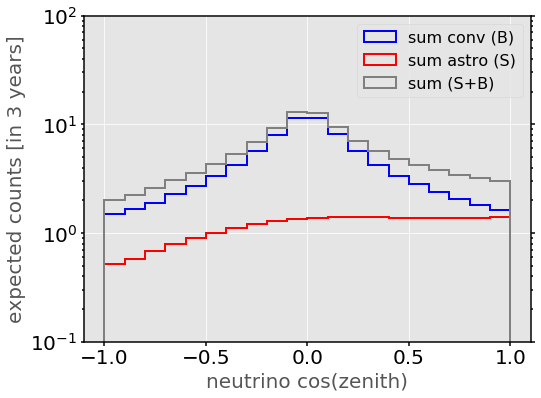

energy cut: 50.0 TeV



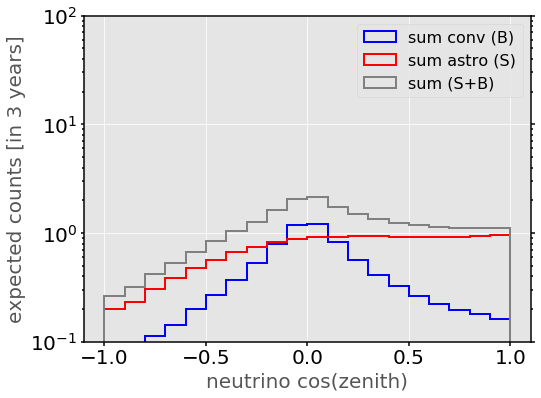

energy cut: 100.0 TeV



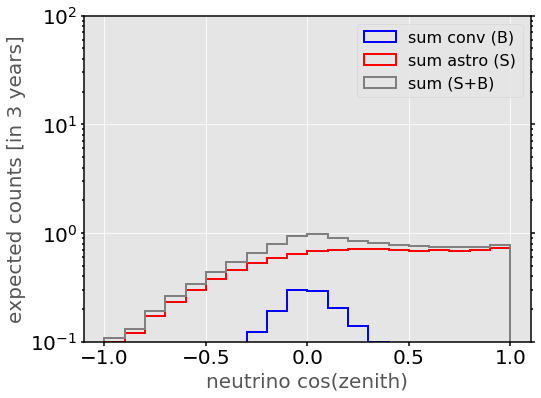

In [11]:
# since all components (nue NC, nue CC and numu NC) produce particle showers in the detector
# no particle ID is possible in this problem
# thus, experimentally, only the sum of the components is observable

var = 'prim_coszenith'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

# because of the strong energy dependence of the signal to background ratio
# let's plot the cos-zenith distribution for different energy cuts

for cut in [0.0, 1.e4, 5.e4, 1.e5]:
    print "energy cut:", cut/1.e3, "TeV"
    print ""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    
    # neutrino energies range from 1 TeV to 10 PeV
    # (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)
    
    edges = np.linspace(-1.0, 1.0, 21)
    
    ltime = 3 * 365 * 24 * 3600
    weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime
    
    idx_energy = df['prim_energy']>cut
    
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_conv[idx_energy], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='solid', label="sum conv (B)")
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_astro[idx_energy], bins=edges, histtype='step', color='red', linewidth=2, linestyle='solid', label="sum astro (S)")
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_astro[idx_energy]+weights_conv[idx_energy], bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum (S+B)")
    
    ax.set_yscale('log')
    ax.set_ylim([1.e-1, 1.e2])
    
    ax.set_xlabel('neutrino cos(zenith)', fontsize=20)
    ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
    for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
              ax.spines[axis].set_color('0.0')
        
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
    ax.yaxis.set_ticks_position('both')
    plt.legend(fontsize=16)
    
    plt.show()


# notice how the atmospheric background prediction is larger in total but vanishes 
# towards higher energies more rapildy than the prediction from the astrophysical (signal) model.
# in addition the relative contributions from the two flavors are vastly different (numu dominates)

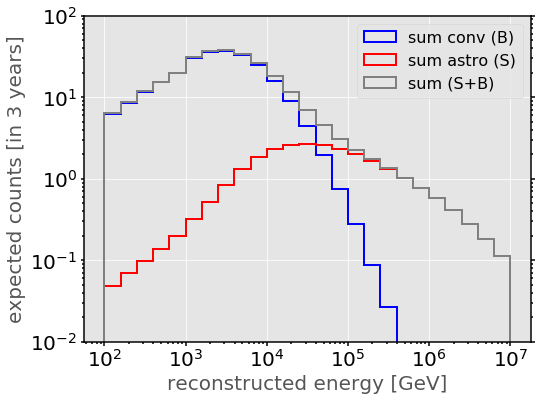

In [12]:
# in a real detector one can not observe the true quantities (latent random variables)
# the observables are "smeared" e.g. by detector resolution and DIS interaction kinematics
# here we visualize the observable quantities that will enter the maximum likelihood fit

var = 'rec_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(2.0, 7.0, 26)
edges = 10**edges

ltime = 3 * 365 * 24 * 3600
weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime

contents, bins, _ = plt.hist(df[var], weights=weights_conv, bins=edges, histtype='step', color='blue', linewidth=2, linestyle='solid', label="sum conv (B)")
contents, bins, _ = plt.hist(df[var], weights=weights_astro, bins=edges, histtype='step', color='red', linewidth=2, linestyle='solid', label="sum astro (S)")
contents, bins, _ = plt.hist(df[var], weights=weights_astro+weights_conv, bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum (S+B)")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e-2, 1.e2])

ax.set_xlabel('reconstructed energy [GeV]', fontsize=20)
ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()

# note how the smearing effect is stronger for the connv component (blue) than the astro component (red) 
# this is because in NC interaction a neutrino is leaving the detector (missing energy)
# the conventional component is dominated by numu - which in our model are purely NC interactions
# the astro component instead is dominanted by nue CC interactions.
# essentially all energy is deposited in the detector 

energy cut: 0.0 TeV



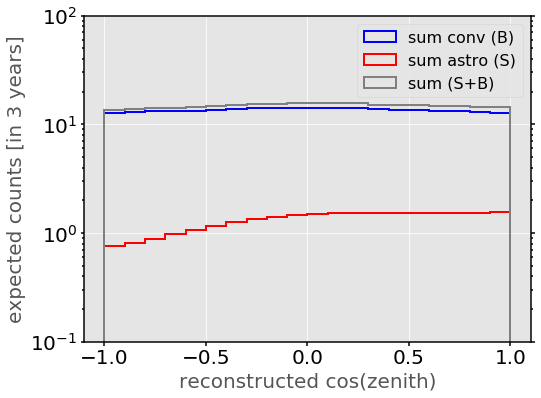

energy cut: 10.0 TeV



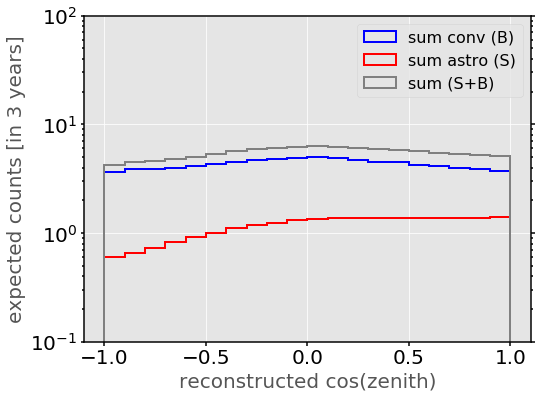

energy cut: 50.0 TeV



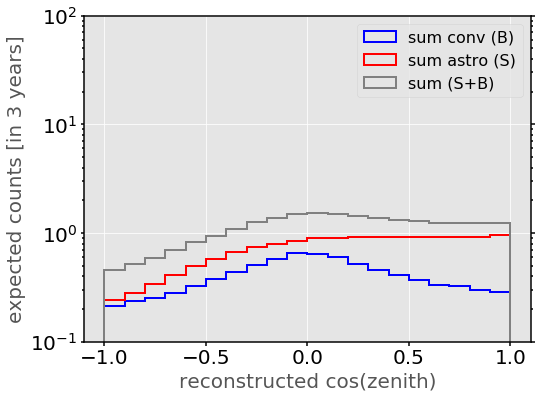

energy cut: 100.0 TeV



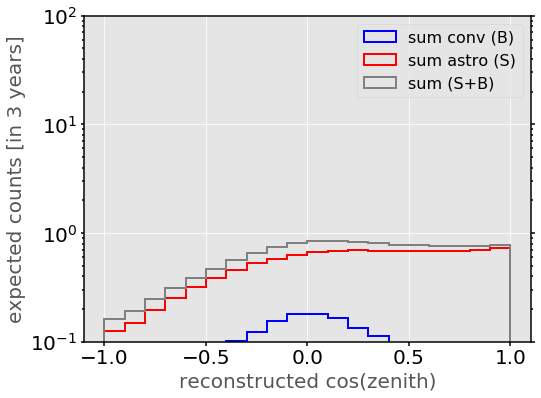

In [13]:
# in a real detector one can not observe the true quantities (latent random variables)
# the observables are "smeared" e.g. by detector resolution and DIS interaction kinematics
# here we visualize the observable quantities that will enter the maximum likelihood fit

var = 'rec_coszenith'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

# because of the strong energy dependence of the signal to background ratio
# let's plot the cos-zenith distribution for different energy cuts

for cut in [0.0, 1.e4, 5.e4, 1.e5]:
    print "energy cut:", cut/1.e3, "TeV"
    print ""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    
    # neutrino energies range from 1 TeV to 10 PeV
    # (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)
    
    edges = np.linspace(-1.0, 1.0, 21)
    
    ltime = 3 * 365 * 24 * 3600
    weights_conv = df['generation_weight'].values * df['conv_flux'].values * ltime
    
    idx_energy = df['prim_energy']>cut
    
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_conv[idx_energy], bins=edges, histtype='step', color='blue', linewidth=2, linestyle='solid', label="sum conv (B)")
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_astro[idx_energy], bins=edges, histtype='step', color='red', linewidth=2, linestyle='solid', label="sum astro (S)")
    contents, bins, _ = plt.hist(df[idx_energy][var], weights=weights_astro[idx_energy]+weights_conv[idx_energy], bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum (S+B)")
    
    ax.set_yscale('log')
    ax.set_ylim([1.e-1, 1.e2])
    
    ax.set_xlabel('reconstructed cos(zenith)', fontsize=20)
    ax.set_ylabel('expected counts [in 3 years]', fontsize=20)
    for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
              ax.spines[axis].set_color('0.0')
        
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
    ax.yaxis.set_ticks_position('both')
    plt.legend(fontsize=16)
    
    plt.show()
    
    
# note how the peak of the conventional flux (blue) is barely visible at lowest energies.
# this is because of the poor angular resolution for particle showers at low energies (which is exaggerated here)
# the resolution improves with increasing energy and the peak becomes visible

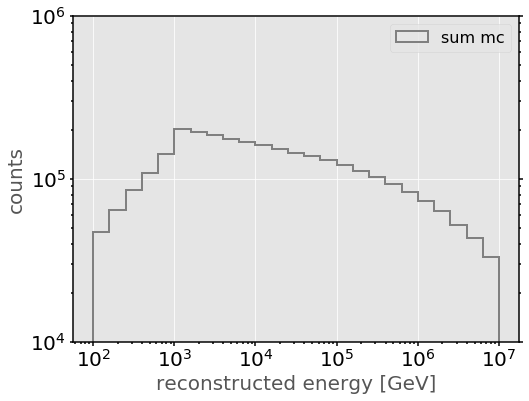

In [6]:
# and finally let's check the unweighted reconstructed energy distribution

var = 'rec_energy'

from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# neutrino energies range from 1 TeV to 10 PeV
# (we use GeV as base-unit: log10(1 TeV / 1 GeV)=3.0)

edges = np.linspace(2.0, 7.0, 26)
edges = 10**edges

contents, bins, _ = plt.hist(df[var], bins=edges, histtype='step', color='gray', linewidth=2, linestyle='solid', label="sum mc")

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e4, 1.e6])

ax.set_xlabel('reconstructed energy [GeV]', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
    
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
plt.legend(fontsize=16)

plt.show()